# CULane Lane Detection

In [2]:
# 1. Setup
from google.colab import drive
import os
import shutil

In [3]:
# 2. Mount Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Define Paths
zip_path = '/content/drive/MyDrive/CULane_mini.zip'
dataset_path = '/content/dataset'

In [5]:
# 4. Copy and Unzip (Fast I/O)
if not os.path.exists(dataset_path):
    print("Copying dataset to local runtime... (This speeds up training)")
    os.makedirs(dataset_path, exist_ok=True)
    # Unzip directly to /content/dataset
    !unzip -q "{zip_path}" -d "{dataset_path}"
    print("Dataset extracted successfully!")
else:
    print("Dataset already exists. Skipping extraction.")

Copying dataset to local runtime... (This speeds up training)
Dataset extracted successfully!


In [6]:
# 5. Install the library we need
!pip install -q segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.4 MB/s eta 0:00:00


Training Samples: 78844
Image Shape: torch.Size([3, 256, 512])
Mask Shape: torch.Size([1, 256, 512])


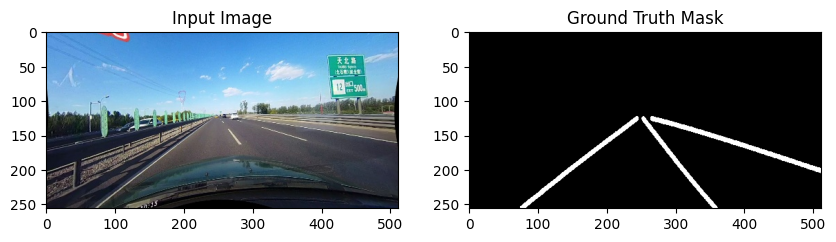

In [ ]:
# Load Dataset

import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

class LaneDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        """
        Args:
            root_dir (string): Root directory of the dataset.
            split (string): "train" or "val".
            transform (callable, optional): Optional transform applied to samples.
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        # Directories for images and masks
        self.images_dir = os.path.join(root_dir, "CULane_mini", split, "images")
        self.masks_dir = os.path.join(root_dir, "CULane_mini", split, "masks")

        # Load all image paths
        self.images = sorted(glob.glob(os.path.join(self.images_dir, "*.jpg")))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image
        img_path = self.images[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask (same filename, .png extension)
        filename = os.path.basename(img_path).replace(".jpg", ".png")
        mask_path = os.path.join(self.masks_dir, filename)
        mask = cv2.imread(mask_path, 0)

        # Normalize image
        image = image / 255.0

        # Normalize mask to binary
        mask = mask / 255.0
        mask = (mask > 0.5).astype(np.float32)

        # Convert to CHW format
        image = np.transpose(image, (2, 0, 1))
        mask = np.expand_dims(mask, axis=0)

        return {
            "image": torch.tensor(image, dtype=torch.float32),
            "mask": torch.tensor(mask, dtype=torch.float32)
        }


# Basic dataset test
train_dataset = LaneDataset(dataset_path, split="train")
print(f"Training Samples: {len(train_dataset)}")

sample = train_dataset[0]
print(f"Image Shape: {sample['image'].shape}")
print(f"Mask Shape: {sample['mask'].shape}")

# Visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample['image'].permute(1, 2, 0))
plt.title("Input Image")
plt.subplot(1, 2, 2)
plt.imshow(sample['mask'][0], cmap="gray")
plt.title("Ground Truth Mask")
plt.show()

In [ ]:
# Training loop 

import segmentation_models_pytorch as smp
import torch
from torch.utils.data import DataLoader
import shutil

# Define model
model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
)

# Hyperparameters
EPOCHS = 10
BATCH_SIZE = 32
LR = 0.0001

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Loss, optimizer, device
loss_fn = smp.losses.DiceLoss(mode="binary")
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on: {device}")

model.to(device)

# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    print(f"Epoch {epoch+1}/{EPOCHS}")

    for i, batch in enumerate(train_loader):
        images = batch["image"].to(device)
        masks = batch["mask"].to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = loss_fn(logits, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if i % 50 == 0:
            print(f"   Batch {i}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} complete. Average Loss: {avg_loss:.4f}")

    # Save checkpoint
    checkpoint_name = f"lane_model_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), checkpoint_name)

    # Backup to Google Drive
    drive_path = f"/content/drive/MyDrive/{checkpoint_name}"
    shutil.copy(checkpoint_name, drive_path)
    print(f"Checkpoint saved to Google Drive: {checkpoint_name}")

# Final model save
torch.save(model.state_dict(), "lane_model_final.pth")
print("Training complete and final model saved.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Training on: cuda
Epoch 1/15
   Batch 0, Loss: 0.9389
   Batch 50, Loss: 0.8688
   Batch 100, Loss: 0.8146
   Batch 150, Loss: 0.7950
   Batch 200, Loss: 0.7213
   Batch 250, Loss: 0.6551
   Batch 300, Loss: 0.6363
   Batch 350, Loss: 0.5517
   Batch 400, Loss: 0.5813
   Batch 450, Loss: 0.5294
   Batch 500, Loss: 0.4652
   Batch 550, Loss: 0.4581
   Batch 600, Loss: 0.3756
   Batch 650, Loss: 0.4066
   Batch 700, Loss: 0.4284
   Batch 750, Loss: 0.3934
   Batch 800, Loss: 0.4228
   Batch 850, Loss: 0.3280
   Batch 900, Loss: 0.3550
   Batch 950, Loss: 0.3583
   Batch 1000, Loss: 0.3085
   Batch 1050, Loss: 0.2970
   Batch 1100, Loss: 0.3370
   Batch 1150, Loss: 0.3388
   Batch 1200, Loss: 0.3272
   Batch 1250, Loss: 0.3214
   Batch 1300, Loss: 0.3128
   Batch 1350, Loss: 0.2278
   Batch 1400, Loss: 0.3556
   Batch 1450, Loss: 0.3337
   Batch 1500, Loss: 0.2778
   Batch 1550, Loss: 0.2703
   Batch 1600, Loss: 0.2700
   Batch 1650, Loss: 0.3315
   Batch 1700, Loss: 0.3069
   Batch 1750,

In [ ]:
# Resume Training

import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import shutil

# Define architecture (must match original training setup)
model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None
)

# Load checkpoint
resume_epoch = 10
checkpoint_path = f"/content/drive/MyDrive/lane_model_epoch_{resume_epoch}.pth"

print(f"Loading weights from: {checkpoint_path}")
model.load_state_dict(torch.load(checkpoint_path))
print("Checkpoint loaded successfully.")

# Training setup
EPOCHS = 10
BATCH_SIZE = 32
LR = 0.0001

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
loss_fn = smp.losses.DiceLoss(mode="binary")
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training loop (resume training)
print(f"Resuming training for {EPOCHS} additional epochs...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    current_epoch = epoch + 1 + resume_epoch
    print(f"Epoch {current_epoch} (Run {epoch+1}/{EPOCHS})")

    for i, batch in enumerate(train_loader):
        images = batch["image"].to(device)
        masks = batch["mask"].to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = loss_fn(logits, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if i % 50 == 0:
            print(f"   Batch {i}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {current_epoch} complete. Average Loss: {avg_loss:.4f}")

    # Save checkpoint
    checkpoint_name = f"lane_model_epoch_{current_epoch}.pth"
    torch.save(model.state_dict(), checkpoint_name)

    drive_path = f"/content/drive/MyDrive/{checkpoint_name}"
    shutil.copy(checkpoint_name, drive_path)
    print(f"Saved: {checkpoint_name}")

print("Extended training complete.")

Erfolg: Modell 'lane_model_epoch_10.pth' wurde auf die CPU geladen!
Generiere Ergebnisse...


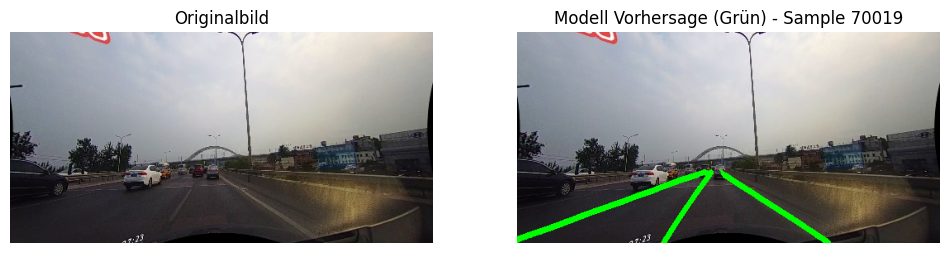

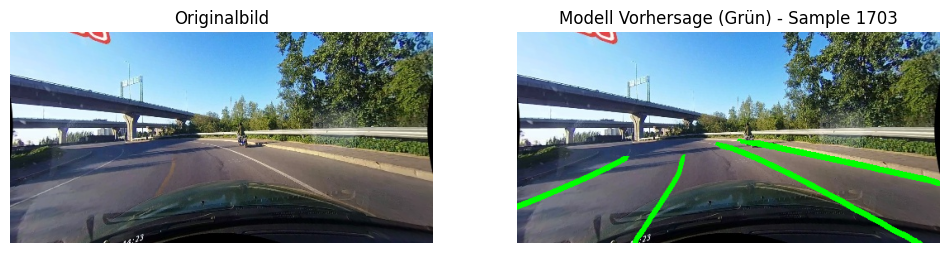

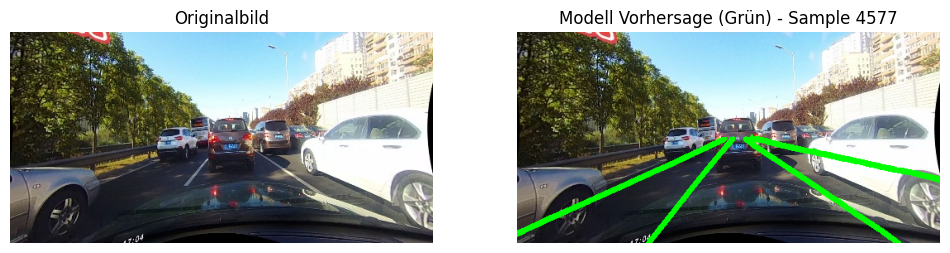

In [ ]:
# Visualization 

import torch
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random

# Define architecture (must match training setup)
model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None
)

# Load saved weights on CPU
checkpoint_path = "/content/drive/MyDrive/lane_model_epoch_10.pth"

try:
    state_dict = torch.load(checkpoint_path, map_location=torch.device("cpu"))
    model.load_state_dict(state_dict)
    print("Model loaded on CPU successfully.")
except FileNotFoundError:
    print(f"Error: checkpoint not found at {checkpoint_path}")

model.eval()

# Overlay visualization function
def visualize_overlay(idx):
    sample = train_dataset[idx]
    image_tensor = sample["image"].unsqueeze(0)

    with torch.no_grad():
        pred_logits = model(image_tensor)
        pred_mask = pred_logits.sigmoid().numpy()[0, 0]

    original_img = sample["image"].permute(1, 2, 0).numpy()

    binary_mask = (pred_mask > 0.5).astype(np.uint8)

    overlay = original_img.copy()

    # Highlight lane in green for visualization
    overlay[:, :, 1] = np.where(binary_mask == 1, 1.0, overlay[:, :, 1])
    overlay[:, :, 0] = np.where(binary_mask == 1, 0.0, overlay[:, :, 0])
    overlay[:, :, 2] = np.where(binary_mask == 1, 0.0, overlay[:, :, 2])

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"Model Prediction (Green) - Sample {idx}")
    plt.axis("off")

    plt.show()

# Test visualization on 3 random samples
print("Generating results...")
for _ in range(3):
    random_idx = random.randint(0, len(train_dataset) - 1)
    visualize_overlay(random_idx)
